In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd

In [2]:
def plot_2Dhist(ND_array, xlabel, ylabel, title = '2D Histogram', xlabel_title = 'x axis', ylabel_title = 'y axis'):
    '''
    ND_array -> input array of NxN dimensions. MAKE SURE ITS NUMPY HSTACKED ARRAY
    xlabel   -> x label list
    ylabel   -> y label list

    To make array suitable for input use function similar to this:
    array = np.hstack((array_1, array_2, array_3, array_4, array_5, array_6)).reshape(-1,array_1.shape[0])
    '''


    nx, ny = ND_array.shape

    indx, indy = np.arange(ny), np.arange(nx)
    x, y = np.meshgrid(indx, indy, indexing='ij')

    fig, ax = plt.subplots()
    ax.imshow(ND_array, interpolation="none")

    for xval, yval in zip(y.flatten(), x.flatten()):
        zval = ND_array[xval, yval]
        t = zval # format value with 1 decimal point
        c = 'k' if zval > 0.75 else 'w' # if dark-green, change text color to white
        ax.text(yval, xval, t, color=c, va='center', ha='center')


    xlabels = xlabel
    ylabels = ylabel

    ax.set_xticks(indx+0.5) # offset x/y ticks so gridlines run on border of boxes
    ax.set_yticks(indy+0.5)
    ax.grid(ls='-', lw=2)
    ax.set_xlabel(xlabel_title)
    ax.set_ylabel(ylabel_title)
    ax.set_title(title)

    # the tick labels, if you want them centered need to be adjusted in 
    # this special way.
    for a, ind, labels in zip((ax.xaxis, ax.yaxis), (indx, indy), 
                            (xlabels, ylabels)):
        a.set_major_formatter(ticker.NullFormatter())
        a.set_minor_locator(ticker.FixedLocator(ind))
        a.set_minor_formatter(ticker.FixedFormatter(labels))

    ax.xaxis.tick_top()

# It works! Functionalise
def scrape_FOM_data(data_path):

    # collect data
    hold = pd.HDFStore(data_path)
    store = hold.keys()
    hold.close()

    # sanitise
    remove = [x.replace("/", "") for x in store]
    split = [(x.split("_")) for x in remove]

    # collect all unique first elements (n_iter)
    unique_0s = list(set([x[0] for i, x in enumerate(split)]))
    # and second elements
    unique_1s = list(set([x[1] for i, x in enumerate(split)]))

    # organise and add leading zero to column (1s)
    unique_0s_ = sorted(unique_0s, key=float)
    unique_1s_ = sorted(unique_1s, key=float)
    unique_1s_ = ["n_iter"] + unique_1s_
    
    # create pandas dataframe with these as the axis
    df = pd.DataFrame(columns = unique_1s_)
    
    # start adding rows babee
    for i in range(len(unique_0s_)):
    	df.loc[i] = [unique_0s_[i]] + list(np.full(shape=len(unique_1s), fill_value=np.nan))

    # set it as the index as well
    df.set_index('n_iter', inplace=True)
    
    # collect the data from each table in the h5 dataframe
    for i in range(len(store)):
        # reformat store data to allow for correct indexing
        remove = store[i].replace("/", "")
        split = remove.split("_")

        play_thing = pd.read_hdf(data_path,key=store[i])
        play_thing.set_index('Cut', inplace=True)
        fom_val = play_thing.loc['FOM_MAX - blob2_E_val (MeV)', 'Relative Efficiency']
            
        df.at[split[0], split[1]] = fom_val
	
    fom_list = []
    for i in range(len(df.index)):
        fom_list.append(df.loc[df.index[i]].to_numpy())
    
    fom_list = np.array(fom_list)
    #reshape into x,y array
    x_vals = (df.columns).to_list()
    y_vals = (df.index).to_list()
    
    # set nans to zeros
    fom_list[np.isnan(fom_list.astype(float))] = 0
    
    fom_list = np.round(fom_list.astype(float), decimals=2)
    
    plot_2Dhist(fom_list, x_vals, y_vals, title = 'FOM LPR', xlabel_title = 'number of iterations', ylabel_title = 'e_cut')
    

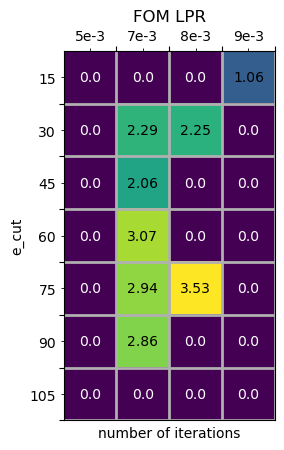

In [9]:
scrape_FOM_data('../../../../Downloads/tmp_out/testing_arena/fiducial_0_1a.h5')

In [4]:
#test_data = pd.read_hdf('../../../../Downloads/tmp_out/testing_arena/fiducial.h5')

ValueError: Dataset(s) incompatible with Pandas data types, not table, or no datasets found in HDF5 file.